# Example: Triangular Mesh for Delineated Watershed

This workflow provides a complete working example to develop a triangular (TIN) mesh for Coweeta watershed. The domain is meshed with standard triangular elements only.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

This workflow creates the following files:

* Mesh file: `Coweeta.exo`, includes all labeled sets

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## FIX ME -- why is this broken without importing netcdf first?
import netCDF4

In [3]:
# setting up logging first or else it gets preempted by another package
import watershed_workflow.ui
watershed_workflow.ui.setup_logging(1)

In [4]:
import os,sys
import logging
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import pandas as pd
import geopandas as gpd
import cftime, datetime
pd.options.display.max_columns = None

import watershed_workflow 
import watershed_workflow.config
import watershed_workflow.source_list
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.daymet
import watershed_workflow.land_cover_properties
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.io
import watershed_workflow.sources.standard_names as names

# set the default figure size for notebooks
plt.rcParams["figure.figsize"] = (8, 6)


# Input: Parameters and other source data

Note, this section will need to be modified for other runs of this workflow in other regions.

In [5]:
# Force Watershed Workflow to pull data from this directory rather than a shared data directory.
# This picks up the Coweeta-specific datasets set up here to avoid large file downloads for 
# demonstration purposes.
#
def splitPathFull(path):
    """
    Splits an absolute path into a list of components such that
    os.path.join(*splitPathFull(path)) == path
    """
    parts = []
    while True:
        head, tail = os.path.split(path)
        if head == path:  # root on Unix or drive letter with backslash on Windows (e.g., C:\)
            parts.insert(0, head)
            break
        elif tail == path:  # just a single file or directory
            parts.insert(0, tail)
            break
        else:
            parts.insert(0, tail)
            path = head
    return parts

cwd = splitPathFull(os.getcwd())

# REMOVE THIS PORTION OF THE CELL for general use outside of Coweeta -- this is just locating 
# the working directory within the WW directory structure
if cwd[-1] == 'Coweeta':
    pass
elif cwd[-1] == 'examples':
    cwd.append('Coweeta')
else:
    cwd.extend(['examples','Coweeta'])
# END REMOVE THIS PORTION

# Note, this directory is where downloaded data will be put as well
data_dir = os.path.join(*(cwd + ['input_data',]))
def toInput(filename):
    return os.path.join(data_dir, filename)

output_dir = os.path.join(*(cwd + ['output_data',]))
def toOutput(filename):
    return os.path.join(output_dir, filename)

work_dir = os.path.join(*cwd)
def toWorkingDir(filename):
    return os.path.join(work_dir, filename)
       

In [6]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Coweeta' # name the domain, used in filenames, etc
coweeta_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

start = cftime.DatetimeNoLeap(2010,8,1)
end = cftime.DatetimeNoLeap(2011,8,1)

# Global Soil Properties
min_porosity = 0.05 # minimum porosity considered "too small"
max_permeability = 1.e-10 # max value considered "too permeable"
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils


logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)


2025-08-15 11:17:47,048 - root - INFO: 
2025-08-15 11:17:47,048 - root - INFO: Meshing shape: Coweeta/input_data/coweeta_basin.shp
2025-08-15 11:17:47,049 - root - INFO: ==============================


In [7]:
# a dictionary of output_filenames -- will include all filenames generated
output_filenames = {}

In [8]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs


In [9]:
# get the shape and crs of the shape
coweeta = watershed_workflow.getShapes(coweeta_shapefile, crs=crs)
coweeta.rename(columns={'AREA' : names.AREA, 'LABEL' : names.NAME}, inplace=True)
coweeta[names.ID] = coweeta.index.values
coweeta.set_index(names.ID, inplace=True, drop=True)

In [10]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.getDefaultSources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDPlus HR']
sources['HUC'] = watershed_workflow.source_list.huc_sources['WaterData WBD']

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
lc_file = ['input_data', 'land_cover', 'land_cover.tif']
dtb_file = ['input_data', 'DTB', 'DTB.tif']
geo_file = ['input_data', 'GLHYMPS', 'GLHYMPS.shp']
if os.path.split(os.getcwd())[-1] == 'examples':
    lc_file.insert(0, 'Coweeta')
    dtb_file.insert(0, 'Coweeta')
    geo_file.insert(0, 'Coweeta')

sources['land cover'] = watershed_workflow.source_list.ManagerRaster(os.path.join(*lc_file))
sources['geologic structure'] = watershed_workflow.source_list.ManagerGLHYMPS(os.path.join(*geo_file))

#
# the Pelletier DTB map is not particularly accurate at Coweeta -- the SoilGrids map seems to be better.  Here we will use a clipped version of that map
sources['depth to bedrock'] = watershed_workflow.source_list.ManagerRaster(os.path.join(*dtb_file))
watershed_workflow.source_list.logSources(sources)

2025-08-15 11:17:47,117 - root - INFO: Using sources:
2025-08-15 11:17:47,117 - root - INFO: --------------
2025-08-15 11:17:47,118 - root - INFO: HUC: WBD WaterData
2025-08-15 11:17:47,118 - root - INFO: hydrography: NHDPlus HR
2025-08-15 11:17:47,118 - root - INFO: DEM: 3DEP
2025-08-15 11:17:47,118 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-08-15 11:17:47,118 - root - INFO: geologic structure: Coweeta/input_data/GLHYMPS/GLHYMPS.shp
2025-08-15 11:17:47,119 - root - INFO: land cover: raster
2025-08-15 11:17:47,119 - root - INFO: LAI: MODIS
2025-08-15 11:17:47,119 - root - INFO: depth to bedrock: raster
2025-08-15 11:17:47,120 - root - INFO: meteorology: None


# Basin Geometry

In this section, we choose the basin, the streams to be included in the stream-aligned mesh, and make sure that all are resolved discretely at appropriate length scales for this work.

## the Watershed

2025-08-15 11:17:47,132 - root - INFO: Removing holes on 1 polygons
2025-08-15 11:17:47,133 - root - INFO:   -- removed interior
2025-08-15 11:17:47,134 - root - INFO:   -- union
2025-08-15 11:17:47,134 - root - INFO: Parsing 1 components for holes
2025-08-15 11:17:47,134 - root - INFO:   -- complete


<Axes: >

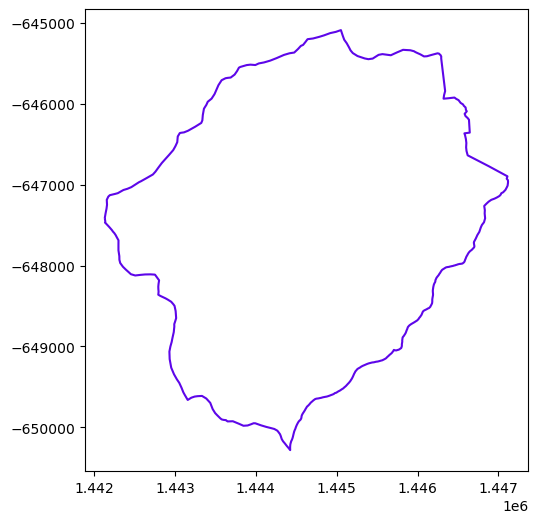

In [11]:
watershed = watershed_workflow.split_hucs.SplitHUCs(coweeta)
watershed.plot()

In [12]:
# download/collect the river network within that shape's bounds
reaches = watershed_workflow.getShapesByGeometry(sources['hydrography'], watershed.exterior, crs, crs)
rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers


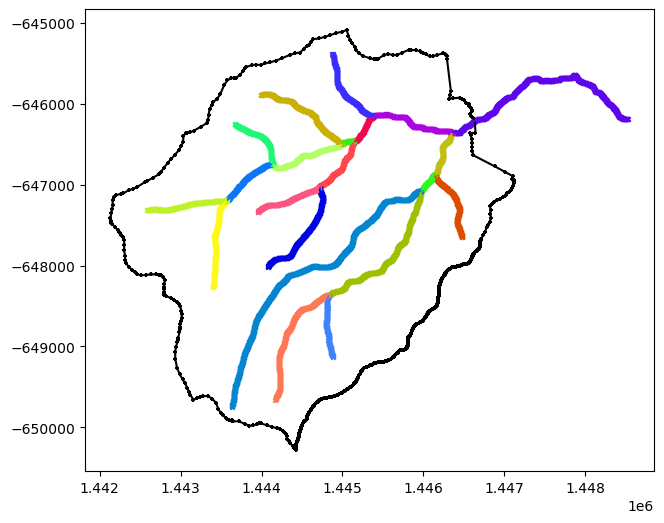

In [13]:
# plot the rivers and watershed
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In [14]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]

In [15]:
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 75, 75, 100, 500)

2025-08-15 11:17:47,657 - root - INFO: 
2025-08-15 11:17:47,657 - root - INFO: Simplifying
2025-08-15 11:17:47,657 - root - INFO: ------------------------------
2025-08-15 11:17:47,657 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-15 11:17:47,658 - root - INFO: Presimplify to remove colinear, coincident points.
2025-08-15 11:17:47,660 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-15 11:17:47,660 - root - INFO: Pruning leaf reaches < 75
2025-08-15 11:17:47,660 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-15 11:17:47,661 - root - INFO: Merging internal reaches < 75
2025-08-15 11:17:47,661 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-15 11:17:47,662

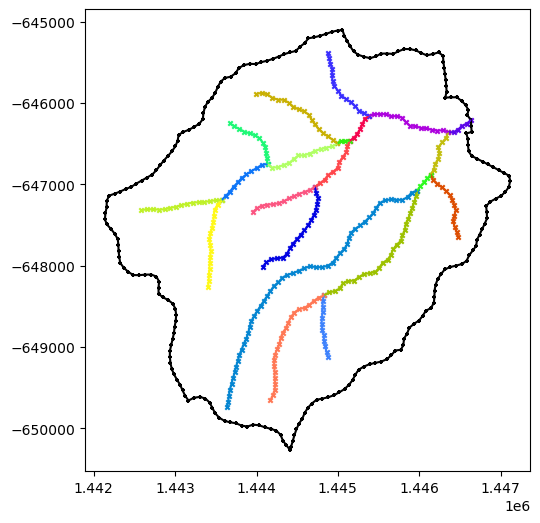

In [16]:
plot(watershed, rivers)

In [17]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
# m = watershed_workflow.makeMap(m)
m

2025-08-15 11:17:48,101 - root - INFO: 
2025-08-15 11:17:48,102 - root - INFO: Triangulation
2025-08-15 11:17:48,102 - root - INFO: ------------------------------
2025-08-15 11:17:48,105 - root - INFO: Triangulating...
2025-08-15 11:17:48,107 - root - INFO:    226 points and 226 facets
2025-08-15 11:17:48,107 - root - INFO:  checking graph consistency
2025-08-15 11:17:48,107 - root - INFO:  tolerance is set to 1.0
2025-08-15 11:17:48,108 - root - INFO:  building graph data structures
2025-08-15 11:17:48,109 - root - INFO:  triangle.build...
2025-08-15 11:17:49,270 - root - INFO:   ...built: 7688 mesh points and 15148 triangles
2025-08-15 11:17:49,270 - root - INFO: Plotting triangulation diagnostics
2025-08-15 11:17:49,634 - root - INFO:   min area = 301.33355712890625
2025-08-15 11:17:49,635 - root - INFO:   max area = 4940.3988037109375


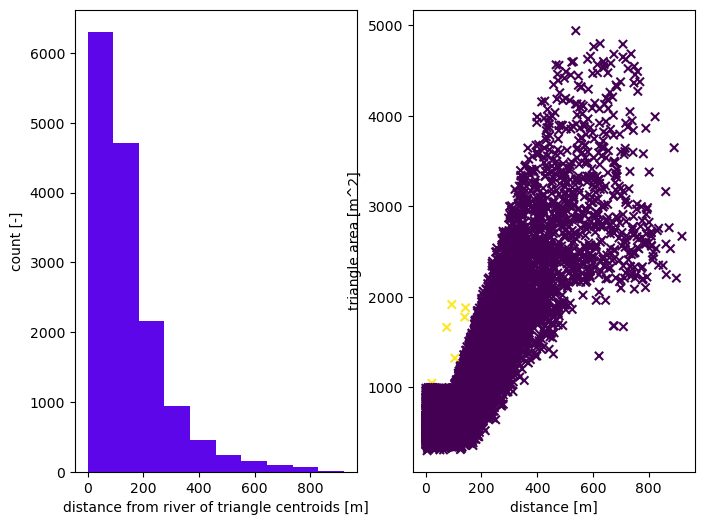

In [18]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000


# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
m2, areas, dists = watershed_workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [19]:
# get a raster for the elevation map, based on NED
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# elevate the triangle nodes to the dem
watershed_workflow.elevate(m2, dem)

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

2025-08-15 11:17:51,294 - matplotlib.axes._base - WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


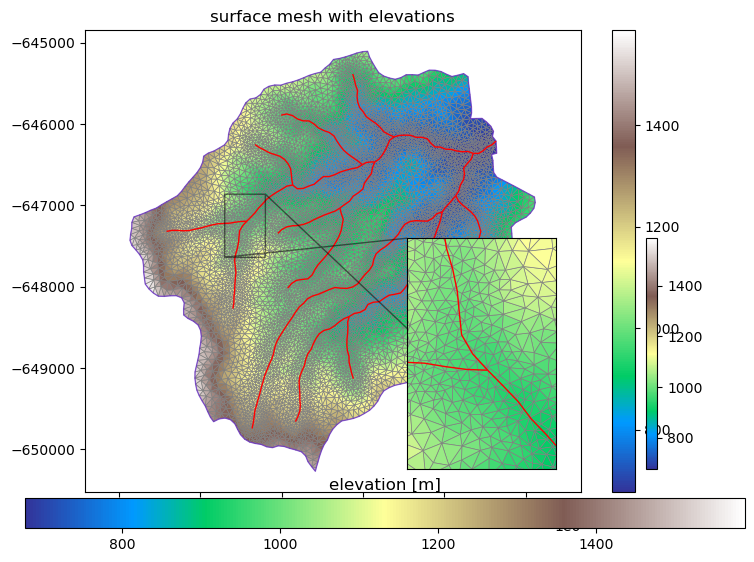

In [20]:
# plot the resulting surface mesh
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

# Get elevation data range
elev_min = m2.coords[:,2].min()
elev_max = m2.coords[:,2].max()

# Create normalized colormap
norm = plt.Normalize(vmin=elev_min, vmax=elev_max)

mp = m2.plot(facecolors='elevation', ax=ax, linewidth=0.5, cmap='terrain', norm=norm)
watershed.plot(ax=ax, alpha=0.5, linewidth=1)
rivers[0].plot(ax=ax, color='red', linewidth=1)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', ax=ax2, cmap='terrain', norm=norm)
rivers[0].plot(ax=ax2, color='red', linewidth=1)
ax2.set_aspect('equal', 'datalim')

xlim = (1.4433e6, 1.4438e6)
ylim = (-647000, -647500)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()

In [21]:
import copy
m2_before_conditioning = copy.deepcopy(m2)

In [22]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fillPitsDual(m2)


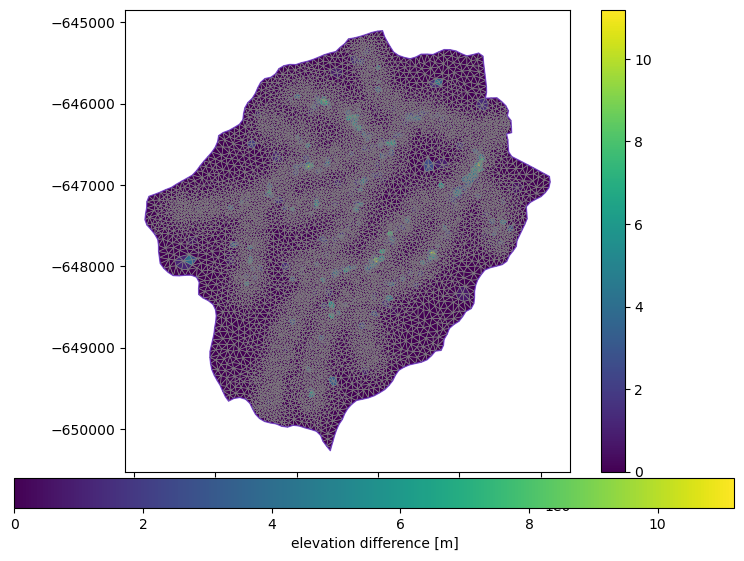

In [23]:
m2_diff = copy.deepcopy(m2)
m2_diff.coords[:,2] = m2.coords[:,2] - m2_before_conditioning.coords[:,2]

# plot the resulting surface mesh
fig, ax = plt.subplots()

# plot the mesh with elevation differences
mp = m2_diff.plot(facecolors='elevation', ax=ax, cmap='viridis')
watershed.plot(ax=ax, alpha=0.5, linewidth=1)

# add colorbar with explicit axes
cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
cbar.set_label('elevation difference [m]')

plt.show()

# Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

## NLCD for LULC

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [24]:
# download the NLCD raster
nlcd = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
logging.info('Found land cover types: {}'.format(set(list(nlcd.values.ravel()))))

2025-08-15 11:17:52,749 - root - INFO: Found land cover dtypes: uint8
2025-08-15 11:17:52,751 - root - INFO: Found land cover types: {np.uint8(71), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(81), np.uint8(82), np.uint8(52), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(90)}


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(82), np.uint8(90)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.8862745098, 0.8862745098, 0.7568627451), (0.85882352941, 0.84705882353, 0.23921568628), (0.66666666667, 0.43921568628, 0.1568627451), (0.72941176471, 0.84705882353, 0.91764705882)]


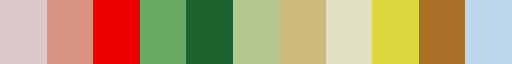

In [25]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

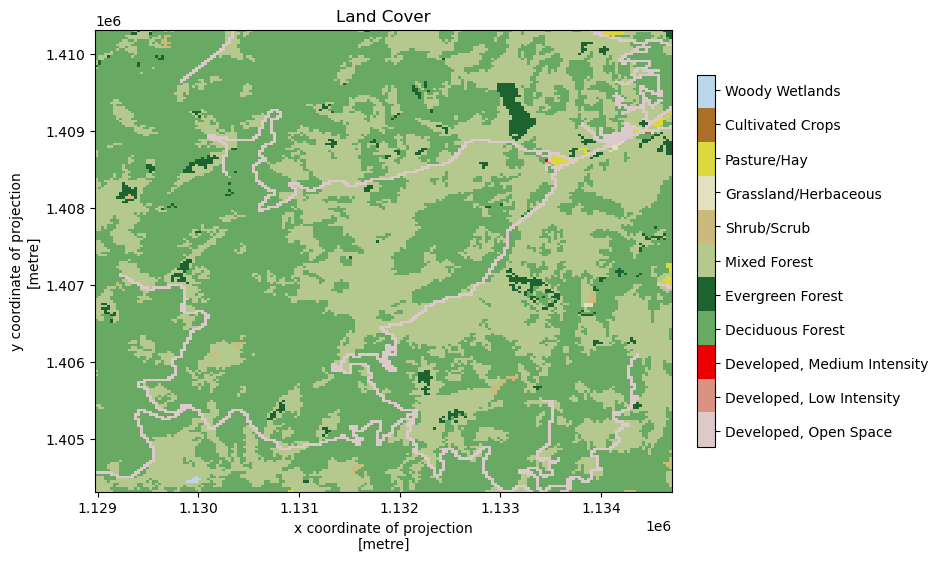

In [26]:
fig, ax = plt.subplots(1,1)
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
ax.set_title('Land Cover')
plt.show()

In [27]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data = pd.DataFrame({'land_cover': m2_nlcd})



In [28]:
# double-check that nan not in the values
assert 127 not in m2_nlcd

# create a new set of labels and indices with only those that actually appear on the mesh
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(m2_nlcd))


making colormap with: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(81)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.85882352941, 0.84705882353, 0.23921568628)]


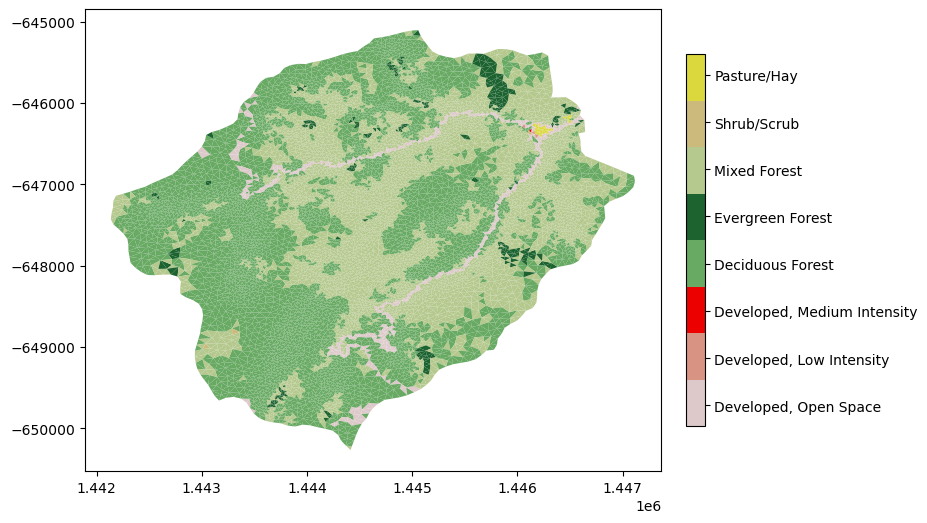

In [29]:
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=plt.gca()) 
plt.show()

In [30]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [31]:
nlcd_labels_dict

{np.uint8(21): 'Developed, Open Space',
 np.uint8(22): 'Developed, Low Intensity',
 np.uint8(23): 'Developed, Medium Intensity',
 np.uint8(41): 'Deciduous Forest',
 np.uint8(42): 'Evergreen Forest',
 np.uint8(43): 'Mixed Forest',
 np.uint8(52): 'Shrub/Scrub',
 np.uint8(81): 'Pasture/Hay'}

In [32]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

21 : CELL : 633 : "Developed, Open Space"
22 : CELL : 3 : "Developed, Low Intensity"
23 : CELL : 1 : "Developed, Medium Intensity"
41 : CELL : 7426 : "Deciduous Forest"
42 : CELL : 279 : "Evergreen Forest"
43 : CELL : 6775 : "Mixed Forest"
52 : CELL : 4 : "Shrub/Scrub"
81 : CELL : 27 : "Pasture/Hay"


## MODIS LAI

Leaf area index is needed on each land cover type -- this is used in the Evapotranspiration calculation.

In [33]:
# download LAI and corresponding LULC datasets -- these are actually already downloaded, 
# as the MODIS AppEEARS API is quite slow
#
# Note that MODIS does NOT work with the noleap calendar, so we have to convert to actual dates first
start_leap = datetime.date(start.year, start.month, start.day)
end_leap = datetime.date(end.year, end.month, end.day)
res = sources['LAI'].getDataset(watershed.exterior, crs, start_leap, end_leap)


2025-08-15 11:17:53,324 - root - INFO: ... searching for: /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LAI_08-01-2010_08-01-2011_35.0891x-83.4947_35.0125x-83.4075.nc
2025-08-15 11:17:53,325 - root - INFO: ... searching for: /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LULC_08-01-2010_08-01-2011_35.0891x-83.4947_35.0125x-83.4075.nc


In [34]:
if isinstance(res, watershed_workflow.sources.manager_modis_appeears.Task):
    assert sources['LAI'].is_ready(res)
    modis_data = sources['LAI'].getDataset(task=res)
else:
    modis_data = res

assert modis_data['LAI'].rio.crs is not None
print(modis_data['LULC'].rio.crs, modis_data['LULC'].dtype)


EPSG:4269 float32


In [35]:
# remove leap day (366th day of any leap year) to match our Noleap Calendar
for k,v in modis_data.items():
    modis_data[k] = watershed_workflow.data.filterLeapDay(v)


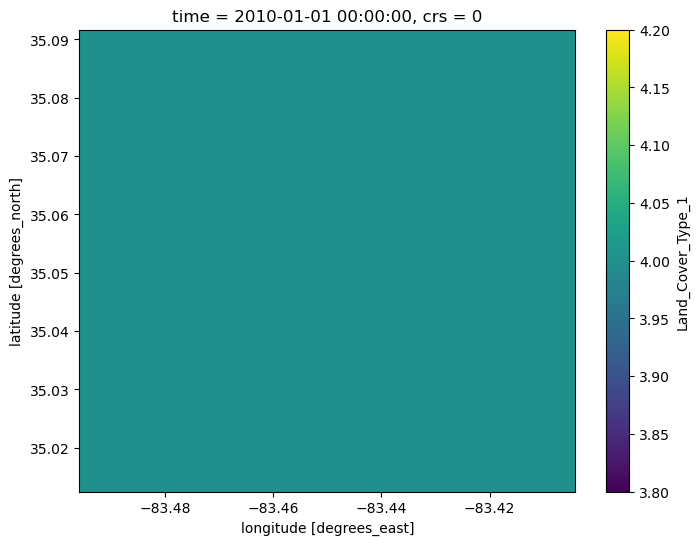

In [36]:
# plot the MODIS data -- note the entire domain is covered with one type for Coweeta (it is small!)
modis_data['LULC'][0].plot.imshow()

In [37]:
# compute the transient time series
modis_lai = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

In [38]:
modis_lai

,time [datetime],Deciduous Broadleaf Forests LAI [-]
0,2010-08-01 00:00:00,3.221277
1,2010-08-05 00:00:00,4.808511
2,2010-08-09 00:00:00,3.442553
3,2010-08-13 00:00:00,4.211702
4,2010-08-17 00:00:00,3.159574
...,...,...
88,2011-07-16 00:00:00,6.364894
89,2011-07-20 00:00:00,4.693617
90,2011-07-24 00:00:00,4.148936
91,2011-07-28 00:00:00,5.281915


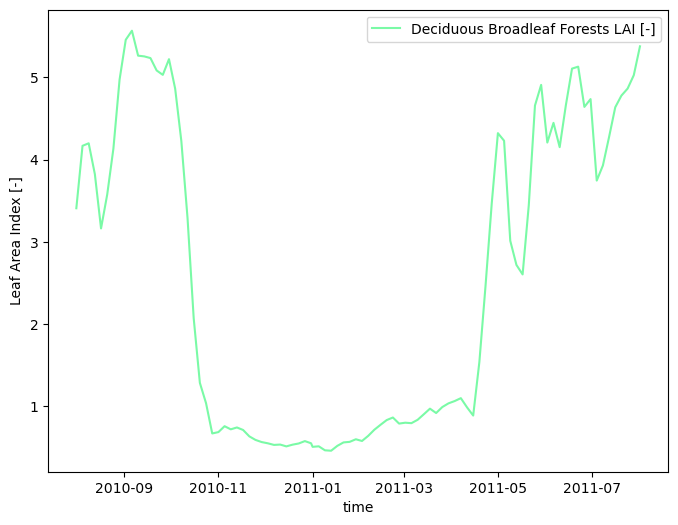

In [39]:
# smooth the data in time
modis_lai_smoothed = watershed_workflow.data.smoothTimeSeries(modis_lai, 'time [datetime]')

watershed_workflow.land_cover_properties.plotLAI(modis_lai_smoothed, indices='MODIS')

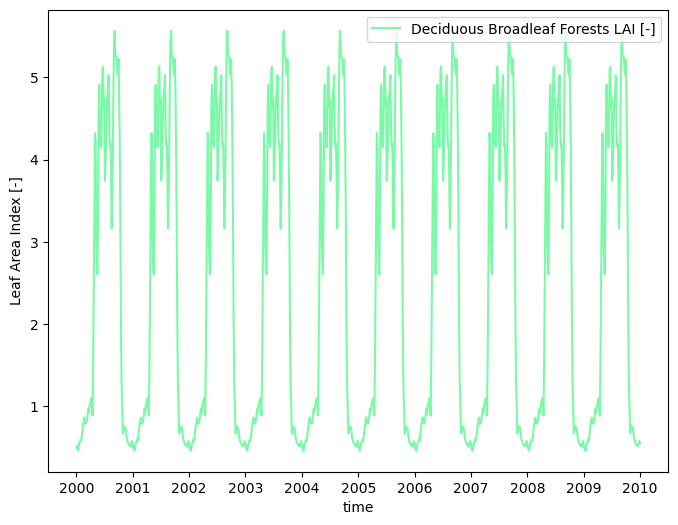

In [40]:
# compute a typical year
modis_lai_typical = watershed_workflow.data.computeAverageYear(modis_lai_smoothed, 'time [datetime]', output_nyears=10, 
                                                                  start_year=2000)

watershed_workflow.land_cover_properties.plotLAI(modis_lai_typical, indices='MODIS')

## Crosswalk of LAI to NLCD LC

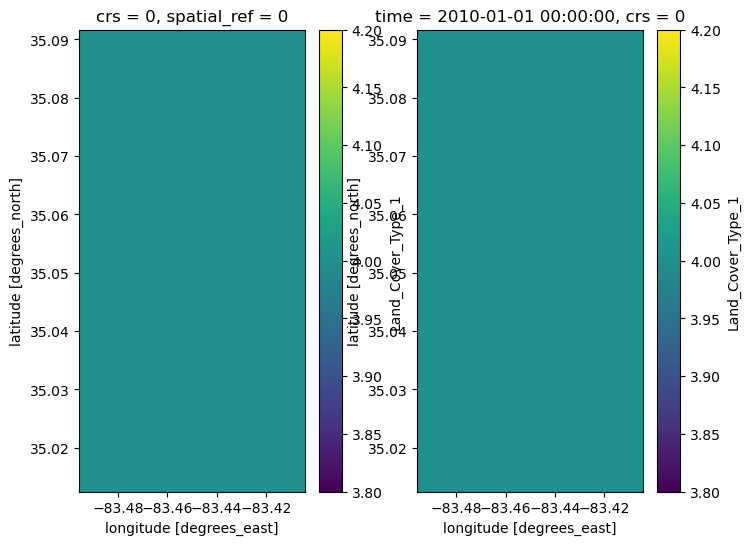

In [41]:
modis_lulc_mode = watershed_workflow.data.computeMode(modis_data['LULC'])

fig, ax = plt.subplots(1,2)
modis_lulc_mode.plot.imshow(ax=ax[0])
modis_data['LULC'][0].plot.imshow(ax=ax[1])
plt.show()

2025-08-15 11:17:54,049 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2025-08-15 11:17:54,050 - root - INFO:   unique MODIS: [np.float32(4.0)]
2025-08-15 11:17:54,050 - root - INFO:   unique NLCD: [np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(41), np.uint8(42), np.uint8(43), np.uint8(52), np.uint8(71), np.uint8(81), np.uint8(82), np.uint8(90)]


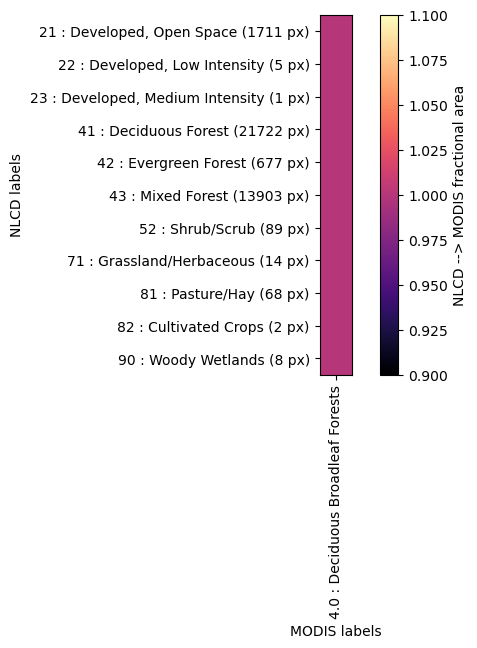

In [42]:
crosswalk = watershed_workflow.land_cover_properties.computeCrosswalk(modis_lulc_mode, nlcd, method='fractional area')

In [43]:
# Compute the NLCD-based time series
nlcd_lai_cyclic_steadystate = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_typical)
nlcd_lai_transient = watershed_workflow.land_cover_properties.applyCrosswalk(crosswalk, modis_lai_smoothed)

watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_cyclic_steadystate)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai_transient)
nlcd_lai_transient

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False
None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time [datetime],"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]",Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Grassland/Herbaceous LAI [-],Pasture/Hay LAI [-],Cultivated Crops LAI [-],Woody Wetlands LAI [-]
0,2010-08-01 00:00:00,3.409422,3.409422,0.0,3.409422,3.409422,3.409422,3.409422,3.409422,3.409422,3.409422,3.409422
1,2010-08-05 00:00:00,4.168389,4.168389,0.0,4.168389,4.168389,4.168389,4.168389,4.168389,4.168389,4.168389,4.168389
2,2010-08-09 00:00:00,4.199164,4.199164,0.0,4.199164,4.199164,4.199164,4.199164,4.199164,4.199164,4.199164,4.199164
3,2010-08-13 00:00:00,3.823556,3.823556,0.0,3.823556,3.823556,3.823556,3.823556,3.823556,3.823556,3.823556,3.823556
4,2010-08-17 00:00:00,3.164286,3.164286,0.0,3.164286,3.164286,3.164286,3.164286,3.164286,3.164286,3.164286,3.164286
...,...,...,...,...,...,...,...,...,...,...,...,...
88,2011-07-16 00:00:00,4.637386,4.637386,0.0,4.637386,4.637386,4.637386,4.637386,4.637386,4.637386,4.637386,4.637386
89,2011-07-20 00:00:00,4.779281,4.779281,0.0,4.779281,4.779281,4.779281,4.779281,4.779281,4.779281,4.779281,4.779281
90,2011-07-24 00:00:00,4.864159,4.864159,0.0,4.864159,4.864159,4.864159,4.864159,4.864159,4.864159,4.864159,4.864159
91,2011-07-28 00:00:00,5.027229,5.027229,0.0,5.027229,5.027229,5.027229,5.027229,5.027229,5.027229,5.027229,5.027229


# Subsurface Soil, Geologic Structure

## NRCS Soils

In [44]:
# get NRCS shapes, on a reasonable crs
nrcs = sources['soil structure'].getShapesByGeometry(watershed.exterior, watershed.crs).to_crs(crs)


2025-08-15 11:17:54,184 - root - INFO: Attempting to download source for target '/home/ecoon/code/watershed_workflow/data/soil_structure/SSURGO/SSURGO_-83.4785_35.0274_-83.4216_35.0738.shp'
2025-08-15 11:17:54,189 - root - INFO:   Found 463 shapes.
2025-08-15 11:17:54,245 - root - INFO: found 42 unique MUKEYs.
2025-08-15 11:17:54,633 - root - INFO: Running Rosetta for van Genutchen parameters
2025-08-15 11:17:54,675 - root - INFO:   ... done
2025-08-15 11:17:54,676 - root - INFO:   requested 42 values
2025-08-15 11:17:54,677 - root - INFO:   got 42 responses


In [45]:
nrcs

,mukey,geometry,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [m],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source,ID,name
0,545800,"MULTIPOLYGON (((1444323.547 -650276.667, 14443...",0.177165,0.431041,0.000139,1.470755,8.079687e-13,2.03,3.429028e-15,0.307246,1.297356,66.356250,19.518750,14.125000,NRCS,545800,NRCS-545800
1,545801,"MULTIPOLYGON (((1442409.341 -648205.513, 14423...",0.177493,0.432741,0.000139,1.469513,8.184952e-13,2.03,3.247236e-15,0.303714,1.292308,66.400000,19.300000,14.300000,NRCS,545801,NRCS-545801
2,545803,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",0.172412,0.400889,0.000150,1.491087,6.477202e-13,2.03,2.800000e-12,0.379163,1.400000,66.799507,21.700493,11.500000,NRCS,545803,NRCS-545803
3,545805,"MULTIPOLYGON (((1447162.174 -649688.276, 14471...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545805,NRCS-545805
4,545806,"MULTIPOLYGON (((1447116.743 -649609.716, 14471...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545806,NRCS-545806
5,545807,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",0.177122,0.388687,0.000083,1.468789,3.412748e-13,2.03,2.800000e-12,0.384877,1.400000,46.721675,41.778325,11.500000,NRCS,545807,NRCS-545807
6,545811,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545811,NRCS-545811
7,545812,"POLYGON ((1443088.752 -650445.293, 1443072.215...",0.185628,0.387114,0.000166,1.473045,4.803887e-13,2.03,1.830706e-12,0.329821,1.488889,69.043320,17.115010,13.841670,NRCS,545812,NRCS-545812
8,545813,"MULTIPOLYGON (((1445736.174 -649979.838, 14457...",0.183468,0.398767,0.000127,1.445858,4.296896e-13,2.03,6.219065e-14,0.349442,1.410667,60.007287,26.226047,13.766667,NRCS,545813,NRCS-545813
9,545814,"MULTIPOLYGON (((1447457.959 -649645.07, 144747...",0.183216,0.399168,0.000125,1.445793,4.285058e-13,2.03,6.060887e-14,0.346424,1.406875,59.510029,26.771221,13.718750,NRCS,545814,NRCS-545814


In [46]:
# create a clean dataframe with just the data we will need for ATS
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(nrcs, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(nrcs, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    nrcs.pop(col)
    
# drop nans
nan_mask = nrcs.isna().any(axis=1)
dropped_mukeys = nrcs.index[nan_mask]

# Drop those rows
nrcs = nrcs[~nan_mask]

assert nrcs['porosity [-]'][:].min() >= min_porosity
assert nrcs['permeability [m^2]'][:].max() <= max_permeability
nrcs

# check for nans
nrcs.isna().any()

mukey                          False
geometry                       False
residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
ID                             False
name                           False
dtype: bool

In [47]:
# Compute the soil color of each cell of the mesh
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, nrcs, 'ID', 
                                                         resolution=50, nodata=-999)

nrcs.set_index('ID', drop=False, inplace=True)

unique_soil_colors = list(np.unique(soil_color_mukey))
if -999 in unique_soil_colors:
    unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
nrcs = nrcs.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
nrcs['ATS ID'] = range(1000, 1000+len(unique_soil_colors))
nrcs.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(nrcs.index, nrcs.ID, nrcs['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


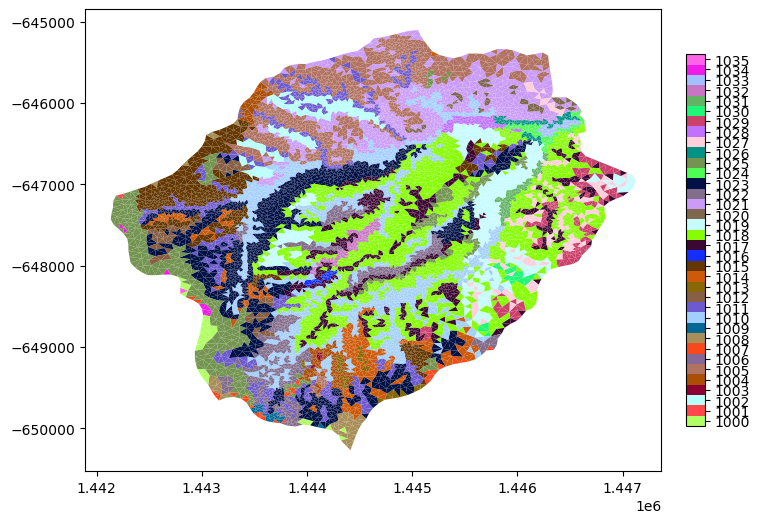

In [48]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(nrcs.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nrcs), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

## Depth to Bedrock from SoilGrids

In [49]:
dtb = sources['depth to bedrock'].getDataset(watershed.exterior, watershed.crs)

# the SoilGrids dataset is in cm --> convert to meters
dtb.values = dtb.values/100.

In [50]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


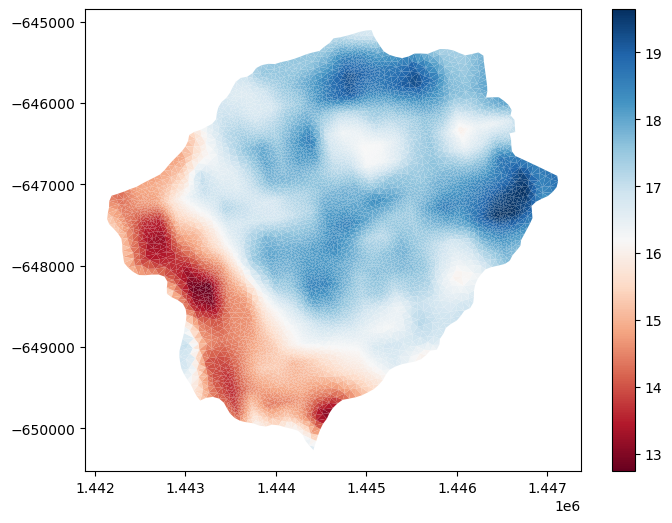

In [51]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

## GLHYMPs Geology

In [52]:
glhymps = sources['geologic structure'].getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, 
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# convert to the right geometry (this should be done in a call to ww.getShapesByGeometry()!
glhymps = glhymps.to_crs(watershed.crs)

# intersect with the buffered geometry -- don't keep extras
glhymps = glhymps[glhymps.intersects(watershed.exterior.buffer(10))]
glhymps

,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,,
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [53]:
# quality check -- make sure glymps shapes cover the watershed
print(glhymps.union_all().contains(watershed.exterior))
glhymps

True


,ID,name,source,permeability [m^2],logk_stdev [-],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
ID,,,,,,,,,,
1,1793338,GLHYMPS-1793338,GLHYMPS,3.019952e-11,1.61,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [54]:
# clean the data
glhymps.pop('logk_stdev [-]')

assert glhymps['porosity [-]'][:].min() >= min_porosity
assert glhymps['permeability [m^2]'][:].max() <= max_permeability
assert glhymps['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

glhymps.isna().any()

ID                             False
name                           False
source                         False
permeability [m^2]             False
porosity [-]                   False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
residual saturation [-]        False
geometry                       False
dtype: bool

In [55]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(glhymps, 'ID')
glhymps

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry
0,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.05,0.001,2.0,0.01,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015...."


In [56]:
# Compute the geo color of each cell of the mesh
geology_color_glhymps = watershed_workflow.getShapePropertiesOnMesh(m2, glhymps, 'index', 
                                                         resolution=50, nodata=-999)

# retain only the unique values of geology that actually appear in our cell mesh
unique_geology_colors = list(np.unique(geology_color_glhymps))
if -999 in unique_geology_colors:
    unique_geology_colors.remove(-999)

# retain only the unique values of geology_color
glhymps = glhymps.loc[unique_geology_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
glhymps['ATS ID'] = range(100, 100+len(unique_geology_colors))
glhymps['TMP_ID'] = glhymps.index
glhymps.reset_index(drop=True, inplace=True)
glhymps.set_index('ATS ID', drop=True, inplace=True)

# create a new geology color using the ATS IDs
geology_color = -np.ones_like(geology_color_glhymps)
for ats_ID, tmp_ID in zip(glhymps.index, glhymps.TMP_ID):
    geology_color[np.where(geology_color_glhymps == tmp_ID)] = ats_ID

glhymps.pop('TMP_ID')

m2.cell_data['geology_color'] = geology_color
                            

In [57]:
geology_color_glhymps.min()

np.int64(0)

## Combine to form a complete subsurface dataset

In [58]:
bedrock = watershed_workflow.soil_properties.getDefaultBedrockProperties()

# merge the properties databases
subsurface_props = pd.concat([glhymps, nrcs, bedrock])

# save the properties to disk for use in generating input file
output_filenames['subsurface_properties'] = toOutput(f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(output_filenames['subsurface_properties'])
subsurface_props


,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015....",NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444323.547 -650276.667, 14443...",545800.0,2.03
1001,545801,NRCS-545801,NRCS,3.247236e-15,0.303714,0.000139,1.469513,0.177493,"MULTIPOLYGON (((1442409.341 -648205.513, 14423...",545801.0,2.03
1002,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",545803.0,2.03
1003,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447162.174 -649688.276, 14471...",545805.0,2.03
1004,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447116.743 -649609.716, 14471...",545806.0,2.03
1005,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",545807.0,2.03
1006,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",545811.0,2.03
1007,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445736.174 -649979.838, 14457...",545813.0,2.03
1008,545814,NRCS-545814,NRCS,6.060887e-14,0.346424,0.000125,1.445793,0.183216,"MULTIPOLYGON (((1447457.959 -649645.07, 144747...",545814.0,2.03


# Extrude the 2D Mesh to make a 3D mesh

In [59]:
# set the floor of the domain as max DTB
dtb_max = np.nanmax(m2.cell_data['dtb'].values)
m2.cell_data['dtb'] = m2.cell_data['dtb'].fillna(dtb_max)

print(f'total thickness: {dtb_max} m')
total_thickness = 50.


total thickness: 19.646575870367812 m


In [60]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimizeDzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.05447108 0.07161305 0.11027281 0.17443206 0.26441087 0.36782677
 0.45697337 0.49999999]
2.0000000000000004


In [61]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [62]:
# 50m total thickness, minus 2m soil thickness, leaves us with 48 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimizeDzs(1, 10, 48, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 2.0, 4.0, 8.0, 11, 11, 11]
print(dzs_geo)
print(sum(dzs_geo))

[2.71113048 5.85796948 9.43304714 9.99786869 9.99998875 9.99999546]
48.0
[1.0, 2.0, 4.0, 8.0, 11, 11, 11]
48.0


In [63]:
# layer extrusion
DTB = m2.cell_data['dtb'].values
soil_color = m2.cell_data['soil_color'].values
geo_color = m2.cell_data['geology_color'].values
soil_thickness = m2.cell_data['soil thickness'].values


# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # use glhymps params
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                                 soil_color,
                                 br_or_geo)

    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    geo_or_br = np.where(depth < DTB, geo_color, 999)

    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarizeExtrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
subsurface_props_used


2025-08-15 11:17:56,272 - root - INFO: Cell summary:
2025-08-15 11:17:56,272 - root - INFO: ------------------------------------------------------------
2025-08-15 11:17:56,273 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2025-08-15 11:17:56,273 - root - INFO: ------------------------------------------------------------
2025-08-15 11:17:56,273 - root - INFO:  00 	| 00 	| 1010 	|   0.050000 	|   0.000000
2025-08-15 11:17:56,274 - root - INFO:  01 	| 01 	| 1010 	|   0.050000 	|   0.050000
2025-08-15 11:17:56,274 - root - INFO:  02 	| 02 	| 1010 	|   0.050000 	|   0.100000
2025-08-15 11:17:56,274 - root - INFO:  03 	| 03 	| 1010 	|   0.120000 	|   0.150000
2025-08-15 11:17:56,274 - root - INFO:  04 	| 04 	| 1010 	|   0.230000 	|   0.270000
2025-08-15 11:17:56,275 - root - INFO:  05 	| 05 	| 1010 	|   0.500000 	|   0.500000
2025-08-15 11:17:56,276 - root - INFO:  06 	| 06 	| 1010 	|   0.500000 	|   1.000000
2025-08-15 11:17:56,276 - root - INFO:  07 	| 07 	| 1010 	|   0.500000 	|   1.5

,ID,name,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],geometry,mukey,thickness [m]
100,"(1793338,)",GLHYMPS-1793338,GLHYMPS,3.019952e-11,0.050000,0.001000,2.000000,0.010000,"MULTIPOLYGON (((1377078.5 -682980.89, 1377015....",NaN,NaN
999,999,bedrock,n/a,1.000000e-16,0.050000,0.000019,3.000000,0.010000,None,NaN,NaN
1000,545800,NRCS-545800,NRCS,3.429028e-15,0.307246,0.000139,1.470755,0.177165,"MULTIPOLYGON (((1444323.547 -650276.667, 14443...",545800.0,2.03
1001,545801,NRCS-545801,NRCS,3.247236e-15,0.303714,0.000139,1.469513,0.177493,"MULTIPOLYGON (((1442409.341 -648205.513, 14423...",545801.0,2.03
1002,545803,NRCS-545803,NRCS,2.800000e-12,0.379163,0.000150,1.491087,0.172412,"MULTIPOLYGON (((1443560.732 -646903.204, 14435...",545803.0,2.03
1003,545805,NRCS-545805,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447162.174 -649688.276, 14471...",545805.0,2.03
1004,545806,NRCS-545806,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1447116.743 -649609.716, 14471...",545806.0,2.03
1005,545807,NRCS-545807,NRCS,2.800000e-12,0.384877,0.000083,1.468789,0.177122,"MULTIPOLYGON (((1444137.771 -649438.148, 14441...",545807.0,2.03
1006,545811,NRCS-545811,NRCS,1.830706e-12,0.329821,0.000166,1.473045,0.185628,"MULTIPOLYGON (((1443093.944 -650401.847, 14430...",545811.0,2.03
1007,545813,NRCS-545813,NRCS,6.219065e-14,0.349442,0.000127,1.445858,0.183468,"MULTIPOLYGON (((1445736.174 -649979.838, 14457...",545813.0,2.03


In [64]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [65]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    

2D labeled sets
---------------
21 : CELL : 633 : "Developed, Open Space"
22 : CELL : 3 : "Developed, Low Intensity"
23 : CELL : 1 : "Developed, Medium Intensity"
41 : CELL : 7426 : "Deciduous Forest"
42 : CELL : 279 : "Evergreen Forest"
43 : CELL : 6775 : "Mixed Forest"
52 : CELL : 4 : "Shrub/Scrub"
81 : CELL : 27 : "Pasture/Hay"

Extruded 3D labeled sets
------------------------

Extruded 3D side sets
---------------------
1 : FACE : 15148 : "bottom"
2 : FACE : 15148 : "surface"
3 : FACE : 3390 : "external sides"
21 : FACE : 633 : "Developed, Open Space"
22 : FACE : 3 : "Developed, Low Intensity"
23 : FACE : 1 : "Developed, Medium Intensity"
41 : FACE : 7426 : "Deciduous Forest"
42 : FACE : 279 : "Evergreen Forest"
43 : FACE : 6775 : "Mixed Forest"
52 : FACE : 4 : "Shrub/Scrub"
81 : FACE : 27 : "Pasture/Hay"


In [66]:
# save the mesh to disk
output_filenames['mesh'] = './coweeta.exo'
try:
    os.remove(output_filenames['mesh'])
except FileNotFoundError:
    pass
m3.writeExodus(output_filenames['mesh'])


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./coweeta.exo


2025-08-15 11:17:59,264 - root - INFO: adding side set: 1
2025-08-15 11:17:59,321 - root - INFO: adding side set: 2
2025-08-15 11:17:59,381 - root - INFO: adding side set: 3
2025-08-15 11:17:59,394 - root - INFO: adding side set: 21
2025-08-15 11:17:59,403 - root - INFO: adding side set: 22
2025-08-15 11:17:59,413 - root - INFO: adding side set: 23
2025-08-15 11:17:59,422 - root - INFO: adding side set: 41
2025-08-15 11:17:59,439 - root - INFO: adding side set: 42
2025-08-15 11:17:59,449 - root - INFO: adding side set: 43
2025-08-15 11:17:59,466 - root - INFO: adding side set: 52
2025-08-15 11:17:59,475 - root - INFO: adding side set: 81


Closing exodus file: ./coweeta.exo
